## Batch NormalizationとLayer Normarlization

## Hook

### .register_hook

In [1]:
# ライブラリ
from functools import partial
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
import torchvision
from torchvision import transforms
import torch.nn.functional as F

from torch.utils.data import DataLoader
%load_ext autoreload
%autoreload 2
import utils
import time

In [2]:
a = torch.ones(5, requires_grad=True)
b = 2*a
# 中間gradを保持
b.retain_grad()

# ここに追加

def print_grad(grad):
    print(grad)
b.register_hook(print_grad)

"""
lambda関数を使って省略
b.register_hook(lambda grad: print(grad))
"""

c = b.mean()

# backward
c.backward()


tensor([0.2000, 0.2000, 0.2000, 0.2000, 0.2000])


In [3]:
print(a)
print(b)
print(c)

tensor([1., 1., 1., 1., 1.], requires_grad=True)
tensor([2., 2., 2., 2., 2.], grad_fn=<MulBackward0>)
tensor(2., grad_fn=<MeanBackward0>)


In [4]:
print(a.grad)
print(b.grad)

tensor([0.4000, 0.4000, 0.4000, 0.4000, 0.4000])
tensor([0.2000, 0.2000, 0.2000, 0.2000, 0.2000])


### .register_forward_hook()

In [5]:
# modelを定義する
conv_model = nn.Sequential(
    # 1x28x28
    nn.Conv2d(1, 4, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),

    # 4x14x14
    nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=1),
    nn.ReLU(), 

    # 8x7x7
    nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),

    # 16x4x4
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),

    nn.Flatten(),
    # 128 -> 32
    nn.Linear(128, 10)
    
)


In [6]:
outputs = {}
def save_output(name, module, inp, out):
    module_name = f'{name}_{str(module)}'
    outputs[module_name] = out.shape
    

In [7]:
# 出力のshapeをdictに保存
for name, module in conv_model.named_modules():
    # print(name, module)
    if name: # 自分自身のmoduleにはhookをつけない
        module.register_forward_hook(partial(save_output, name))
        

In [8]:
def print_hooks(model):
    for name , module in model.named_modules():
        if hasattr(module, "_forward_hooks"):
            for hook in module._forward_hooks.values():
                print(f'Module {name} has forward hook : {hook}')
    
    for name , module in model.named_modules():
        if hasattr(module, "_forward_hooks"):
            for hook in module._backward_hooks.values():
                print(f'Module {name} has backward hook : {hook}')

In [9]:
print_hooks(conv_model)

Module 0 has forward hook : functools.partial(<function save_output at 0x7fff1350ca60>, '0')
Module 1 has forward hook : functools.partial(<function save_output at 0x7fff1350ca60>, '1')
Module 2 has forward hook : functools.partial(<function save_output at 0x7fff1350ca60>, '2')
Module 3 has forward hook : functools.partial(<function save_output at 0x7fff1350ca60>, '3')
Module 4 has forward hook : functools.partial(<function save_output at 0x7fff1350ca60>, '4')
Module 5 has forward hook : functools.partial(<function save_output at 0x7fff1350ca60>, '5')
Module 6 has forward hook : functools.partial(<function save_output at 0x7fff1350ca60>, '6')
Module 7 has forward hook : functools.partial(<function save_output at 0x7fff1350ca60>, '7')
Module 8 has forward hook : functools.partial(<function save_output at 0x7fff1350ca60>, '8')
Module 9 has forward hook : functools.partial(<function save_output at 0x7fff1350ca60>, '9')


In [10]:
from functools import partial

# 元となる関数を定義
def power(base, exponent):
    return base ** exponent

# 部分適用した関数を適用
square = partial(power, exponent=2)

# 部分適用した関数の利用
print(square(5))  # 出力25


25


### forwardでhookを発動

In [11]:
X = torch.randn((1, 1, 28, 28))
output = conv_model(X)

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


In [12]:
outputs

{'0_Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))': torch.Size([1, 4, 14, 14]),
 '1_ReLU()': torch.Size([1, 4, 14, 14]),
 '2_Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))': torch.Size([1, 8, 7, 7]),
 '3_ReLU()': torch.Size([1, 8, 7, 7]),
 '4_Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))': torch.Size([1, 16, 4, 4]),
 '5_ReLU()': torch.Size([1, 16, 4, 4]),
 '6_Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))': torch.Size([1, 32, 2, 2]),
 '7_ReLU()': torch.Size([1, 32, 2, 2]),
 '8_Flatten(start_dim=1, end_dim=-1)': torch.Size([1, 128]),
 '9_Linear(in_features=128, out_features=10, bias=True)': torch.Size([1, 10])}

## .register_full_backward_hook()

In [13]:
grads = {}
def save_grad_in(name, module, grad_in, grad_out):
    module_name = f'{name}_{str(module)}'
    grads[module_name] = grad_in

# 出力のshapeをdictに保存
for name, module in conv_model.named_modules():
    # print(name, module)
    if name: # 自分自身のmoduleにはhookをつけない
        module.register_full_backward_hook(partial(save_grad_in, name))
        

In [14]:
print_hooks(conv_model)

Module 0 has forward hook : functools.partial(<function save_output at 0x7fff1350ca60>, '0')
Module 1 has forward hook : functools.partial(<function save_output at 0x7fff1350ca60>, '1')
Module 2 has forward hook : functools.partial(<function save_output at 0x7fff1350ca60>, '2')
Module 3 has forward hook : functools.partial(<function save_output at 0x7fff1350ca60>, '3')
Module 4 has forward hook : functools.partial(<function save_output at 0x7fff1350ca60>, '4')
Module 5 has forward hook : functools.partial(<function save_output at 0x7fff1350ca60>, '5')
Module 6 has forward hook : functools.partial(<function save_output at 0x7fff1350ca60>, '6')
Module 7 has forward hook : functools.partial(<function save_output at 0x7fff1350ca60>, '7')
Module 8 has forward hook : functools.partial(<function save_output at 0x7fff1350ca60>, '8')
Module 9 has forward hook : functools.partial(<function save_output at 0x7fff1350ca60>, '9')
Module 0 has backward hook : functools.partial(<function save_grad_in 

In [15]:
# backward 
X = torch.rand((1, 1, 28, 28))
output = conv_model(X)
loss = output.mean()
loss.backward()

In [16]:
grads

{'9_Linear(in_features=128, out_features=10, bias=True)': (tensor([[-2.0122e-03,  2.8533e-02, -1.9424e-03,  1.4424e-03, -1.2341e-02,
            1.7394e-02, -1.1877e-03, -1.6332e-02, -2.0163e-03, -3.0688e-02,
            1.3686e-03,  3.0109e-02,  4.2802e-04,  2.9999e-02,  4.2365e-03,
           -1.5933e-02, -3.0791e-03, -1.7939e-02,  6.9218e-03, -8.5529e-03,
           -5.9185e-03, -9.9154e-03,  1.0575e-02,  2.5702e-02, -5.8650e-03,
           -5.6979e-03, -1.1726e-02,  7.3027e-03,  2.2863e-02, -2.3577e-02,
           -9.2290e-03,  1.2251e-03,  2.0332e-03,  2.2893e-02, -4.1120e-02,
            2.4013e-02, -9.6837e-03, -3.3043e-04,  7.6884e-03,  3.8774e-03,
            1.8997e-02,  2.5762e-02,  8.6649e-03, -2.1238e-02, -1.8741e-02,
            7.1328e-03, -1.3827e-02,  7.9288e-03,  1.6535e-02, -3.8006e-03,
           -1.0224e-02,  2.1887e-02,  2.2151e-02,  7.2359e-03,  5.1576e-03,
            2.6339e-05,  1.6762e-02,  1.2210e-02,  2.9260e-03, -4.4498e-02,
            1.8644e-03,  1.4831

In [17]:
## Activationの分布

In [18]:
# model 
conv_model = nn.Sequential(
    # 1x28x28
    nn.Conv2d(1, 4, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),

    # 4x14x14
    nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),

    # 8x7x7
    nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),

    # 16x4x4
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),

    # 32x2x2
    nn.Flatten(),
    nn.Linear(128, 10)

)

outputs = {}
def save_output(name, module, inp, out):
    module_name = f'{name}_{str(module)}'
    outputs[module_name] = out.shape

# 出力のshapeをdictに保存
for name, module in conv_model.named_modules():
    if name: 
        module.register_forward_hook(partial(save_output, name))
        

In [19]:
# forward 
# for module in conv_model:
#     print(module)
# # relu分のリストを作成
act_means = [[]  for module in conv_model if isinstance(module, nn.ReLU)]
act_stds = [[]  for module in conv_model if isinstance(module, nn.ReLU)]

def save_out_stats(i, module, inp, out):
    act_means[i].append(out.mean().item())
    act_stds[i].append(out.std().item())
    
relu_layers = [module for module in conv_model if isinstance(module, nn.ReLU)]
for i, relu in enumerate(relu_layers):
    relu.register_forward_hook(partial(save_out_stats, i))

# 上記のものをclass化する

class ActivationStatistics:

    def __init__(self, model):
        self.model = model
        self.act_means = [ [] for module in self.model if isinstance(module, nn.ReLU)]
        self.act_stds = [ [] for module in self.model if isinstance(module, nn.ReLU)]
        self.register_hook()

    def register_hook(self):
        relu_layers = [module for module in self.model if isinstance(module, nn.ReLU)]
        for i, relu in enumerate(relu_layers):
            relu.register_forward_hook(partial(self.save_out_stats, i))

    def save_out_stats(self, i, module, inp, out):
        # relu層からout(mean, std)は計算グラフを作成するので、計算グラフを作成しない処理 -> detach
        # detachをするとCPUで学習するので、明示的にCPUで処理するようにする。
        self.act_means[i].append(out.detach().cpu().mean().item())
        self.act_stds[i].append(out.detach().cpu().std().item())

    def get_statstics(self):
        return self.act_means, self.act_stds

    def plot_statistics(self):
        fig, axs = plt.subplots(1, 2, figsize=(15, 5))
        for act_mean in self.act_means:
            axs[0].plot(act_mean)
        axs[0].set_title('Activation means')
        plt.legend(range(len(self.act_means)))
        

        for act_std in self.act_stds:
            axs[1].plot(act_std)
        axs[1].set_title('Activation means')
        plt.legend(range(len(self.act_stds)))
        
        plt.show()

In [20]:
act_stats = ActivationStatistics(conv_model)

In [21]:
[module for module in conv_model if isinstance(module, nn.ReLU)]

[ReLU(), ReLU(), ReLU(), ReLU()]

In [22]:
# データ準備
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5,)),
])



train_dataset = torchvision.datasets.FashionMNIST('./fminist_data', train = True, download=True, transform=transform)
val_dataset = torchvision.datasets.FashionMNIST('./fminist_data', train = False, download=True, transform=transform)

# dataloader 
train_loader = DataLoader(train_dataset, batch_size = 1024, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size = 1024, num_workers=4)


100%|██████████| 26421880/26421880 [00:11<00:00, 2354272.83it/s]


Extracting ./fminist_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./fminist_data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 124325.25it/s]


Extracting ./fminist_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./fminist_data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:02<00:00, 2150538.79it/s]


Extracting ./fminist_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./fminist_data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 1868005.62it/s]


Extracting ./fminist_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./fminist_data/FashionMNIST/raw



In [23]:
opt = optim.SGD(conv_model.parameters(), lr=0.6)

In [24]:
train_losses, val_losses, val_accuracy = utils.learn(conv_model, train_loader, val_loader, opt, F.cross_entropy, num_epoch=3)


epoch: 0: train error: 2.305491384813341, validation error: 2.284063982963562, validation accuracy: 0.11444714590907097


epoch: 1: train error: 1.7820407637095048, validation error: 1.2905234217643737, validation accuracy: 0.5504045784473419


epoch: 2: train error: 0.9992625945705479, validation error: 0.8245462000370025, validation accuracy: 0.699035394191742


In [25]:
act_means, act_stds = act_stats.get_statstics()

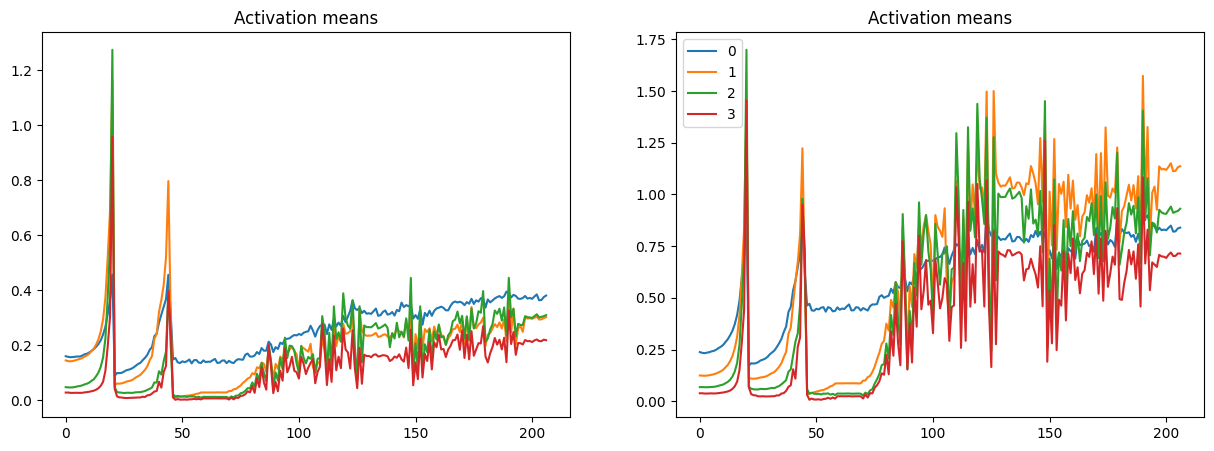

In [26]:
act_stats.plot_statistics()

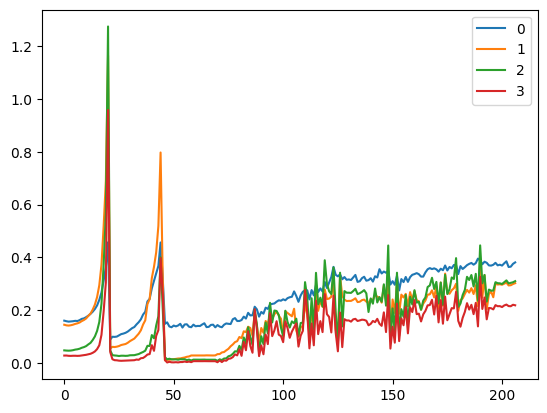

In [27]:
# act_means   # [[], [], [], []]
for act_mean in act_means:
    plt.plot(act_mean)

plt.legend(range(len(act_means)))

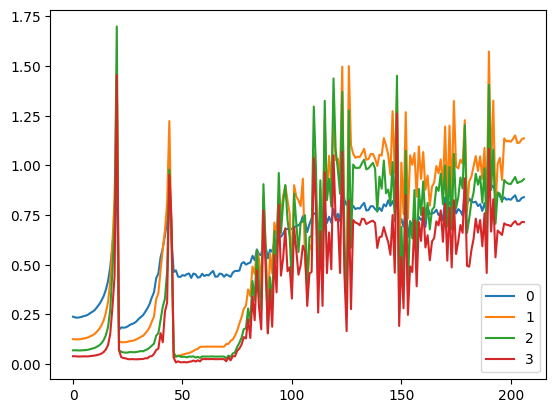

In [28]:
# act_means   # [[], [], [], []]
for act_std in act_stds:
    plt.plot(act_std)

plt.legend(range(len(act_std)))

このグラフから何を言っているのかと
1層目のReLU層の平均値をみると、stepがめっちゃ上がって下がって、いる
-> 学習がしにくい状況になっている
つまり、分布が変わっている
各Activation分布を見ることで、学習が滑らかに進んではいない
平均が上がったり、下がったりしている -> 内部共変量が起きている

100%|██████████| 9912422/9912422 [00:05<00:00, 1924244.57it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 32088925.52it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:01<00:00, 1291072.16it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 9974098.83it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



ValueError: Expected input batch_size (16) to match target batch_size (64).